In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
import pickle
import json

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
from bcnf.simulation.physics import physics_ODE_simulation
from bcnf.models.cnf import CondRealNVP
from bcnf.models.feature_network import FullyConnectedFeatureNetwork
from bcnf.train.train import train_CondRealNVP
from bcnf.utils import get_dir, ParameterIndexMapping
from bcnf.simulation.sampling import generate_data
from bcnf.simulation.resimulation import resimulate
from bcnf.utils import partconv1d, get_gaussian_kernel

In [3]:
dataset_name = "test_resimulation_data_T2_dt_1_15"

In [4]:
MODEL_NAME = 'bcnf_traj_test_resimulation_data_T2_dt_1_15'

## Data

In [5]:
T = 2
dt = 1/15

In [6]:
if not os.path.exists(os.path.join(get_dir('data', 'bcnf-data'), dataset_name + '.pkl')):
    data = generate_data(
        n=2000,
        output_type="trajectory",
        dt=dt,
        T=T,
        config_file=os.path.join(get_dir("configs"), "throw_upwards_no_a.yaml"),
        verbose=True,
        break_on_impact=False,
        name=dataset_name
    )
else:
    with open(os.path.join(get_dir('data', 'bcnf-data'), dataset_name + '.pkl'), 'rb') as f:
        data = pickle.load(f)

In [7]:
all_parameters = list(data.keys())
print(all_parameters)

['x0_x', 'x0_y', 'x0_z', 'v0_x', 'v0_y', 'v0_z', 'g_x', 'g_y', 'g_z', 'w_x', 'w_y', 'w_z', 'b', 'm', 'a_x', 'a_y', 'a_z', 'cam_radian_array', 'r', 'A', 'Cd', 'rho', 'cam_radius', 'cam_angles', 'cam_heights', 'trajectory']


In [8]:
parameter_selection = ['x0_x','x0_y','x0_z','v0_x','v0_y','v0_z','g_x', 'g_y', "g_z",'w_x','w_y','w_z','b', 'm', 'a_x', 'a_y', 'a_z','r', 'A', 'Cd', 'rho']
for p in parameter_selection:
    assert p in all_parameters

In [9]:
parameter_index_mapping = ParameterIndexMapping(parameter_selection)

In [10]:
X_list = data['trajectory']

In [11]:
X = np.array(X_list)
y = parameter_index_mapping.vectorize(data)

print(f'{X.shape=}')
print(f'{y.shape=}')

X.shape=(2000, 30, 3)
y.shape=(2000, 21)


In [12]:
STEPS = X.shape[1]
d = X.shape[2]

print(f'{STEPS=}')
print(f'{d=}')

STEPS=30
d=3


In [13]:
X_tensor = torch.tensor(X.reshape(X.shape[0], -1), dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

print(f'{X_tensor.shape=}')
print(f'{y_tensor.shape=}')

X_tensor.shape=torch.Size([2000, 90])
y_tensor.shape=torch.Size([2000, 21])


## Model

In [14]:
with open(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), 'config.json'), 'r') as f:
    config = json.load(f)

In [15]:
feature_network = FullyConnectedFeatureNetwork(
    sizes = [config['model_kwargs']['feature_network_input_size']] + [config['model_kwargs']['condition_size']],
    dropout=config['model_kwargs']['feature_network_dropout']
).to(device)

In [16]:
cnf = CondRealNVP(
    size=config['model_kwargs']['size'],
    nested_sizes=[config['model_kwargs']['model_nested_size']] * config['model_kwargs']['model_nested_layers'],
    n_blocks=config['model_kwargs']['model_n_blocks'],
    dropout=config['model_kwargs']['model_dropout'],
    n_conditions=config['model_kwargs']['condition_size'],
    act_norm=config['model_kwargs']['model_act_norm'],
    feature_network=feature_network,
    parameter_index_mapping=parameter_index_mapping).to(device)

In [17]:
print(f'Number of parameters: {cnf.n_params:,}')

Number of parameters: 132,461


## Load Model

In [18]:
loss_history = {}

In [19]:
cnf.load_state_dict(torch.load(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), "state_dict.pt")))

with open(os.path.join(get_dir('models', 'bcnf-models', MODEL_NAME), 'loss_history.pkl'), 'rb') as f:
    loss_history = pickle.load(f)

In [20]:
cnf.eval();

## Resimulation

In [ ]:
# https://github.com/scipy/scipy/issues/15940
X_resimulation = resimulate(
    model=cnf,
    T=T,
    dt=dt,
    y_hat=None,
    data_dict=data,
    X=X_tensor,
    m_samples=1_000,
    break_on_impact=False
)

In [63]:
X_resimulation.shape

(2000, 1000, 30, 3)

In [64]:
X.shape

(2000, 30, 3)

## Resimulation Error

In [65]:
X_error = (X_resimulation - X[:, None, :, :])

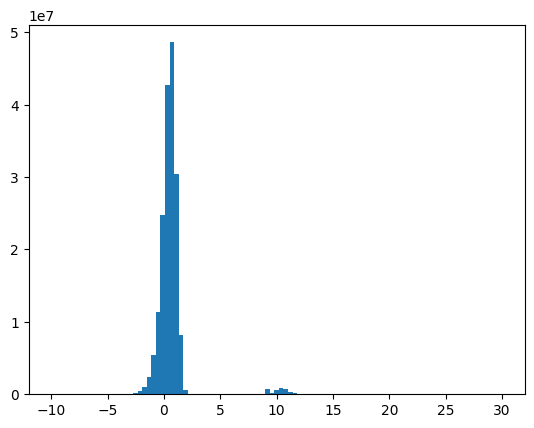

In [76]:
plt.hist(np.log10(np.abs(X_error[np.isfinite(X_error)]).flatten()), bins=np.linspace(-10, 30, 100));

In [77]:
# Average over 
X_errors = np.nanmedian(X_error, axis=(1, 3))

/tmp/ipykernel_19525/1647630515.py:5: RuntimeWarning: invalid value encountered in log10
  axes[0].hist(np.log10(X_errors.flatten()), bins=np.linspace(0, 32, 32), alpha=0.5, label='Resimulation error');


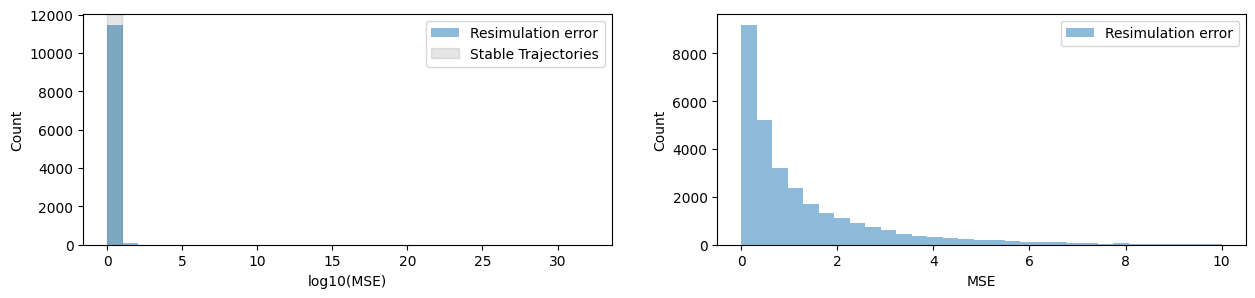

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))

zoom_until = 10

axes[0].hist(np.log10(X_errors.flatten()), bins=np.linspace(0, 32, 32), alpha=0.5, label='Resimulation error');
axes[0].axvspan(0, np.log10(zoom_until), alpha=0.1, color='k', label='Stable Trajectories')

axes[0].set_xlabel('log10(MSE)')
axes[0].set_ylabel('Count')

axes[0].legend()

axes[1].hist(X_errors.flatten(), bins=np.linspace(0, zoom_until, 32), alpha=0.5, label='Resimulation error');

axes[1].set_xlabel('MSE')
axes[1].set_ylabel('Count')

axes[1].legend()

In [79]:
# For each simulation i, find the indices j (sample), t (timestep), k in [i, j, t, -1] where X_resimulation changes sign from positive to negative
impact_indices = [np.where(np.diff((X_resimulation[i, :, :, -1] > 0).astype(int), axis=1) == -1) for i in range(X_resimulation.shape[0])]

# Get the potitions at the impact indices for each simulation i and sample j at time t
X_resimulation_impact_positions = [X_resimulation[i, impact_indices[i][0], impact_indices[i][1], :] for i in range(X_resimulation.shape[0])]

In [80]:
true_impact_indices = np.where(np.diff((X[:, :, -1] > 0).astype(int)) == -1)

X_val_impact_positions = X[true_impact_indices[0], true_impact_indices[1]]

In [81]:
true_impact_indices[0]

array([  62,  109,  113,  204,  242,  248,  314,  331,  338,  358,  398,
        414,  467,  487,  525,  543,  561,  630,  661,  756,  758,  763,
        818,  896,  902,  944,  953,  967, 1044, 1049, 1097, 1153, 1154,
       1163, 1207, 1224, 1236, 1271, 1284, 1328, 1380, 1416, 1485, 1487,
       1543, 1550, 1618, 1644, 1650, 1710, 1712, 1746, 1783, 1814, 1852,
       1856, 1896, 1922, 1951])

In [82]:
show_index = 113
# Check if the desired validation trajectory has an impact
assert show_index in true_impact_indices[0]

X_val_impact_position = X[show_index, true_impact_indices[1][np.where(true_impact_indices[0] == show_index)[0]][0], :] 

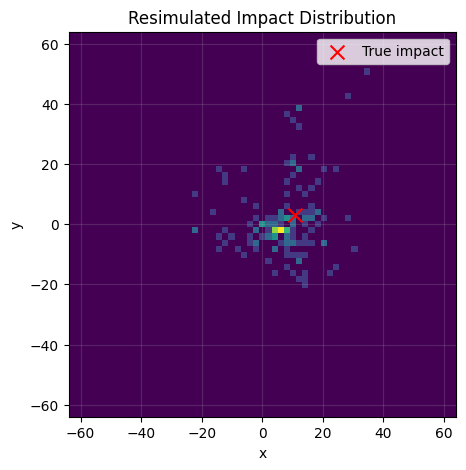

In [83]:
# Plot a heatmap of X_resimulation[0, impact_indices, :2]
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.hist2d(X_resimulation_impact_positions[show_index][:, 0], X_resimulation_impact_positions[show_index][:, 1], bins=np.linspace(-64, 64, 64), cmap='viridis');
ax.scatter(X_val_impact_position[0], X_val_impact_position[1], color='red', s=100, marker='x', label='True impact')
ax.grid(axis='both', alpha=0.2);
ax.set_xlabel('x');
ax.set_ylabel('y');
ax.set_title('Resimulated Impact Distribution');
ax.legend();

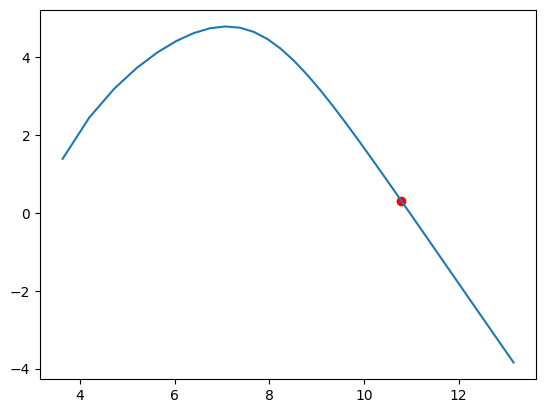

In [84]:
plt.plot(X[show_index, :, 0], X[show_index, :, -1], label='True trajectory');
plt.scatter(X_val_impact_position[0], X_val_impact_position[-1], color='red', label='Impact');

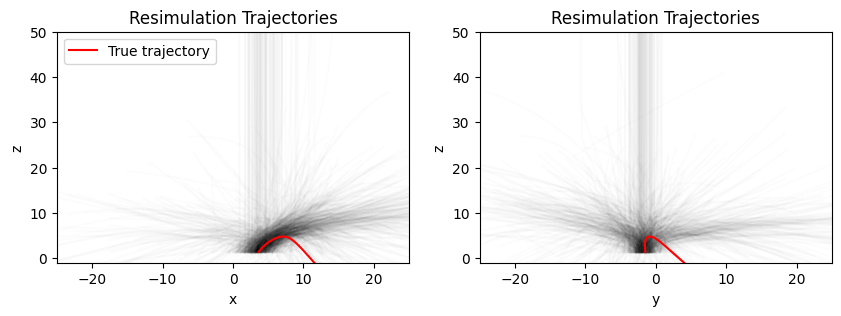

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))

n_trajectories = 3000
max_time = 1000


for i, (ax, ax_name) in enumerate(zip(axes, ['x', 'y'])):
    ax.plot(X_resimulation[show_index, :n_trajectories, :max_time, i].T, X_resimulation[show_index, :n_trajectories, :max_time, 2].T, alpha=0.01, color='black');
    ax.plot(X[show_index, :, i], X[show_index, :, 2], label='True trajectory', color='red');
    ax.set_xlim(-25, 25)
    ax.set_ylim(-1, 50)
    ax.set_xlabel(ax_name);
    ax.set_ylabel('z');
    ax.set_title('Resimulation Trajectories');

axes[0].legend();